<a href="https://www.kaggle.com/code/minseo14/arc-task-00d62c1b-with-cnn?scriptVersionId=189980909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ARC Task 00d62c1b with CNN!
> ### Models in this page are specialized only for the single data, 00d62c1b. 
> ### Still a necessary step though!

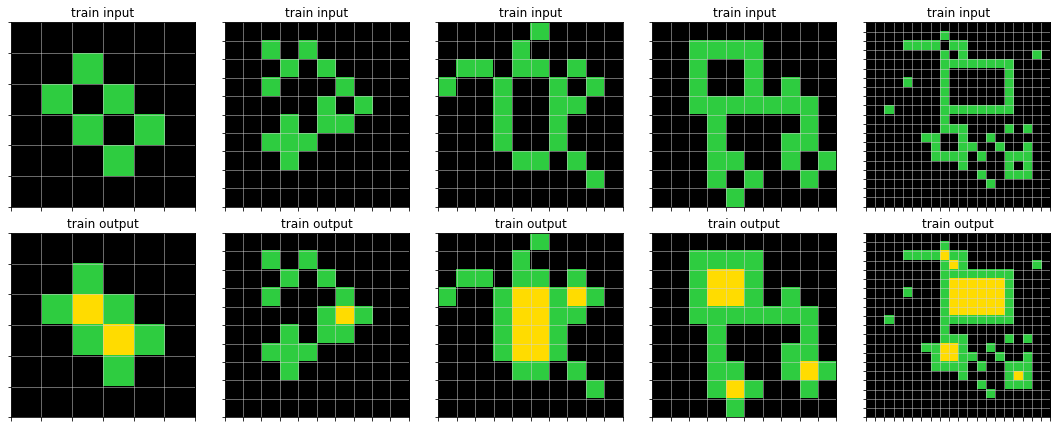

## Abastract
    CNNs seems have a limitation to detect all borders without long term memory.
### Next Step 
    Apply boundary fill algorithm from the border of the image detecting nearby pixels having the same color. 
    Then detect the significant rest pixels

### Extention (To aproach end-to-end)
    Classify whether the shape is stable or not.
    Predict what kind of pattern/roles each task/color has.
    
### Citation of code
> [Basic Attention Model - deep-learning-from-scratch-2](https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch08)

---

# Step 0: Setup

## 0-1. Install Libraries and Import Modules

> ### Add Path

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arcsourcecode/data.py
/kaggle/input/arcsourcecode/train.py
/kaggle/input/arcsourcecode/test.py
/kaggle/input/arcsourcecode/classify.py
/kaggle/input/arcsourcecode/2_00d62c1b.png
/kaggle/input/arcsourcecode/configs/train.yaml
/kaggle/input/arcsourcecode/configs/test.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInput.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_test.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_train.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInputIgnoreColor_test.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInputIgnoreColor_train.yaml
/kaggle/input/arcsourcecode/configs/test/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/test/FillerKeepInput.yaml
/kaggle/input/arcsourcecode/configs/train/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/train/FillerKeepInput.yaml
/kaggle/input/

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/arcsourcecode')

> ### Install Hydra

In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=fea35996aa7e7607ee015d40f36360fed51872836568ff3ab1d2d6d67a0f7a1e
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


> ### Load Config Files and Train/Test Functions

In [4]:
from omegaconf import OmegaConf
import torch
from torch import nn
import torch.nn.functional as F

from train import train
from test import test

In [5]:
base_path = '/kaggle/input/arc-prize-2024/'
config_path = '/kaggle/input/arcsourcecode/configs/'

def load_config(path, config_path=config_path):
    return OmegaConf.load(config_path + path)

# Hyperparameters for Training
def load_train_config(ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_train.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_train = load_config("train/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_train.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_train = load_config("train/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
        
    config_train = OmegaConf.merge({'data': config_data, 'model': config_model, 'train': config_train, 'test': config_test})
    config_train.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    config_train.save_path = './output/'
    
    return config_train

# Hyperparameters for Testing
def load_test_config(ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_test.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_test.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
    
    config_test = OmegaConf.merge({'data': config_data, 'model': config_model, 'test': config_test})
    config_test.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    
    return config_test

## 0-2. Data Augmentation (Rotation, Flipping)

Data size: 5

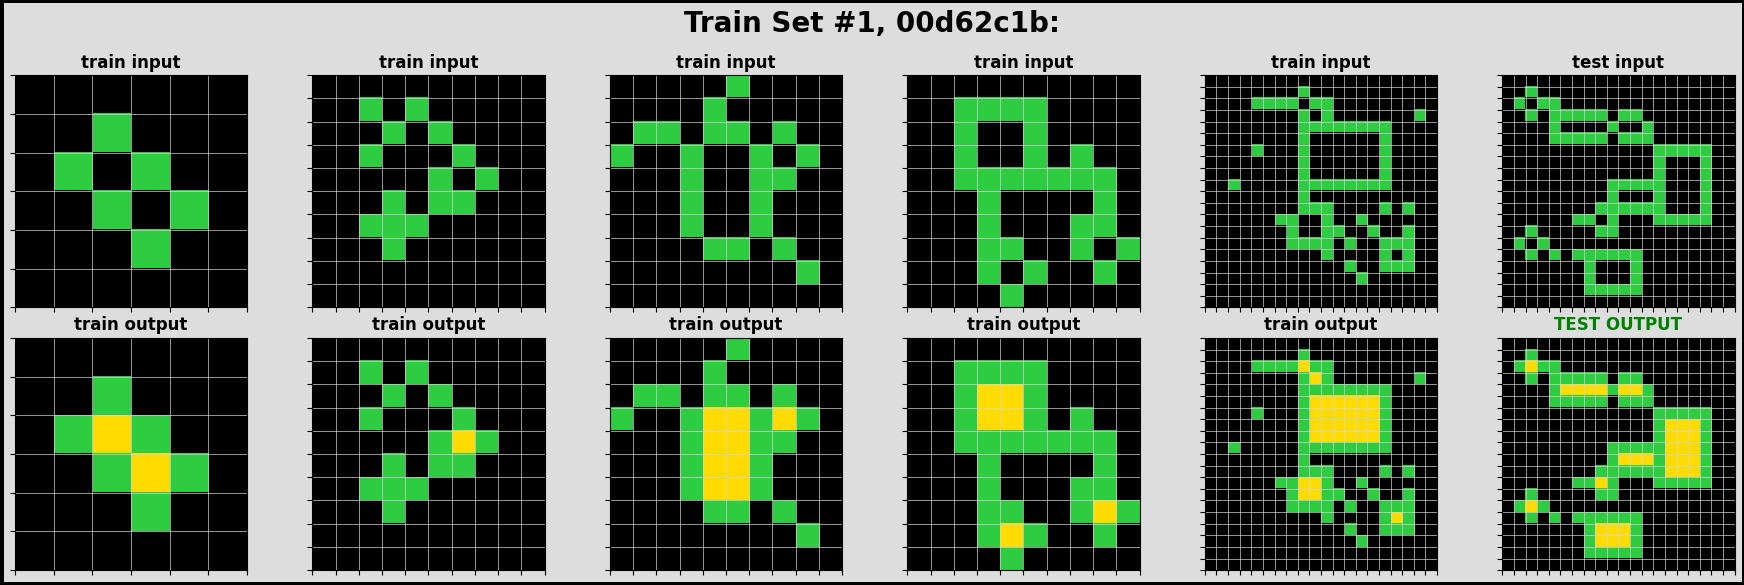

In [6]:
from rich import print
from data import ARCDataset
from arc_prize.constants import get_challenges_solutions_filepath
from arc_prize.utils.visualize import plot_task
from classify import ARCDataClassifier


data_category = 'train'
challenges, solutions = get_challenges_solutions_filepath(data_category, base_path)

# Filtering Dataset
filter_funcs = (
    ARCDataClassifier.in_data_codes_f(['00d62c1b']),
#     ARCDataClassifier.is_same_shape_f(True),
#     ARCDataClassifier.is_n_m_colored_in_out_f(2, 3),
#     ARCDataClassifier.is_dominent_color_stable_f(True),
)

dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category)
    break

Data size: 34

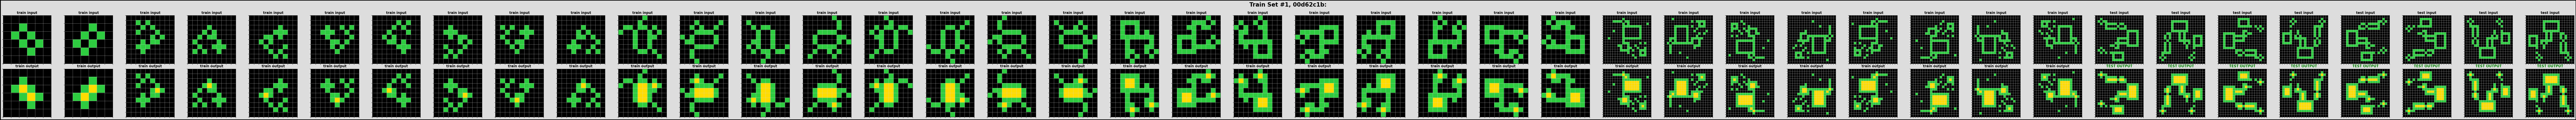

In [7]:
dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs, augment_data=True)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category='Train')
    break

# Step 1: Consider which pixel to be substituted

## 1-1. Predict the positions to be substituted

In [8]:
config = load_train_config(ignore_color=True)
train(config)

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    max_epochs: 60
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false
save_path: ./output/

FillerKeepInputIgnoreColorL(
  (model): FillerKeepInputIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
          (out): Linear(in_features=32, out_features=1, bias=False)
        )
        (norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

2024-07-27 09:34:39.186834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 09:34:39.186971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 09:34:39.318594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInputIgnoreColor │ 42.0 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss          │      0 │ train │
└───┴────────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 36.9 K                                                                                           
Non-trainable params: 5.1 K                                                                                        
Total params: 42.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Epoch 1 | Train loss: 3.616169 | N Pixels Wrong: 2029

Epoch 2 | Train loss: 3.214243 | N Pixels Wrong: 1034

Epoch 3 | Train loss: 3.011622 | N Pixels Wrong: 796

Epoch 4 | Train loss: 2.911196 | N Pixels Wrong: 540

Epoch 5 | Train loss: 2.854016 | N Pixels Wrong: 375

Epoch 6 | Train loss: 2.816961 | N Pixels Wrong: 230

Epoch 7 | Train loss: 2.790361 | N Pixels Wrong: 173

Epoch 8 | Train loss: 2.776073 | N Pixels Wrong: 152

Epoch 9 | Train loss: 2.766626 | N Pixels Wrong: 138

Epoch 10 | Train loss: 2.762230 | N Pixels Wrong: 113

Epoch 11 | Train loss: 2.759624 | N Pixels Wrong: 75

Epoch 12 | Train loss: 2.757381 | N Pixels Wrong: 55

Epoch 13 | Train loss: 2.753692 | N Pixels Wrong: 39

Epoch 14 | Train loss: 2.752770 | N Pixels Wrong: 39

Epoch 15 | Train loss: 2.751202 | N Pixels Wrong: 31

Epoch 16 | Train loss: 2.750301 | N Pixels Wrong: 25

Epoch 17 | Train loss: 2.749852 | N Pixels Wrong: 20

Epoch 18 | Train loss: 2.749232 | N Pixels Wrong: 6

Epoch 19 | Train loss: 2.748825 | N Pixels Wrong: 2

Epoch 20 | Train loss: 2.748498 | N Pixels Wrong: 2

Epoch 21 | Train loss: 2.748301 | N Pixels Wrong: 2

Epoch 22 | Train loss: 2.748199 | N Pixels Wrong: 1

Epoch 23 | Train loss: 2.748080 | N Pixels Wrong: 0

Epoch 24 | Train loss: 2.747982 | N Pixels Wrong: 0

Epoch 25 | Train loss: 2.747915 | N Pixels Wrong: 0

Epoch 26 | Train loss: 2.747878 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInputIgnoreColor_26ep.ckpt

Epoch 27 | Train loss: 2.747845 | N Pixels Wrong: 0

Epoch 28 | Train loss: 2.747796 | N Pixels Wrong: 0

Epoch 29 | Train loss: 2.747770 | N Pixels Wrong: 0

Epoch 30 | Train loss: 2.747777 | N Pixels Wrong: 0

Epoch 31 | Train loss: 2.747809 | N Pixels Wrong: 0

Epoch 32 | Train loss: 2.747722 | N Pixels Wrong: 0

Epoch 33 | Train loss: 2.747715 | N Pixels Wrong: 0

Epoch 34 | Train loss: 2.747645 | N Pixels Wrong: 0

Epoch 35 | Train loss: 2.747630 | N Pixels Wrong: 0

Epoch 36 | Train loss: 2.747613 | N Pixels Wrong: 0

Epoch 37 | Train loss: 2.747592 | N Pixels Wrong: 0

Epoch 38 | Train loss: 2.747574 | N Pixels Wrong: 0

Epoch 39 | Train loss: 2.747566 | N Pixels Wrong: 0

Epoch 40 | Train loss: 2.747568 | N Pixels Wrong: 0

Epoch 41 | Train loss: 2.747652 | N Pixels Wrong: 0

Epoch 42 | Train loss: 2.747695 | N Pixels Wrong: 0

Epoch 43 | Train loss: 2.747638 | N Pixels Wrong: 0

Epoch 44 | Train loss: 2.747651 | N Pixels Wrong: 0

Epoch 45 | Train loss: 2.747640 | N Pixels Wrong: 0

Epoch 46 | Train loss: 2.747657 | N Pixels Wrong: 0

Epoch 47 | Train loss: 2.747620 | N Pixels Wrong: 0

Epoch 48 | Train loss: 2.747595 | N Pixels Wrong: 0

Epoch 49 | Train loss: 2.747583 | N Pixels Wrong: 0

Epoch 50 | Train loss: 2.747575 | N Pixels Wrong: 0

Epoch 51 | Train loss: 2.747604 | N Pixels Wrong: 0

Epoch 52 | Train loss: 2.747672 | N Pixels Wrong: 0

Epoch 53 | Train loss: 2.747707 | N Pixels Wrong: 0

Epoch 54 | Train loss: 2.747724 | N Pixels Wrong: 0

Epoch 55 | Train loss: 2.747613 | N Pixels Wrong: 0

Epoch 56 | Train loss: 2.747617 | N Pixels Wrong: 0

Epoch 57 | Train loss: 2.747678 | N Pixels Wrong: 0

Epoch 58 | Train loss: 2.747648 | N Pixels Wrong: 0

Epoch 59 | Train loss: 2.747602 | N Pixels Wrong: 0

Epoch 60 | Train loss: 2.747628 | N Pixels Wrong: 0

Seed used 8517012248996560849

Model saved to: ./output/FillerKeepInputIgnoreColor.ckpt

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false

Task: 00d62c1b | train 1 |  77.78% correct | 8 Pixels Wrong

Task: 00d62c1b | train 2 |  84.00% correct | 16 Pixels Wrong

Task: 00d62c1b | train 3 |  69.00% correct | 31 Pixels Wrong

Task: 00d62c1b | train 4 |  65.00% correct | 35 Pixels Wrong

Task: 00d62c1b | train 5 |  75.50% correct | 98 Pixels Wrong

Task: 00d62c1b |  test 1 |  70.00% correct | 120 Pixels Wrong

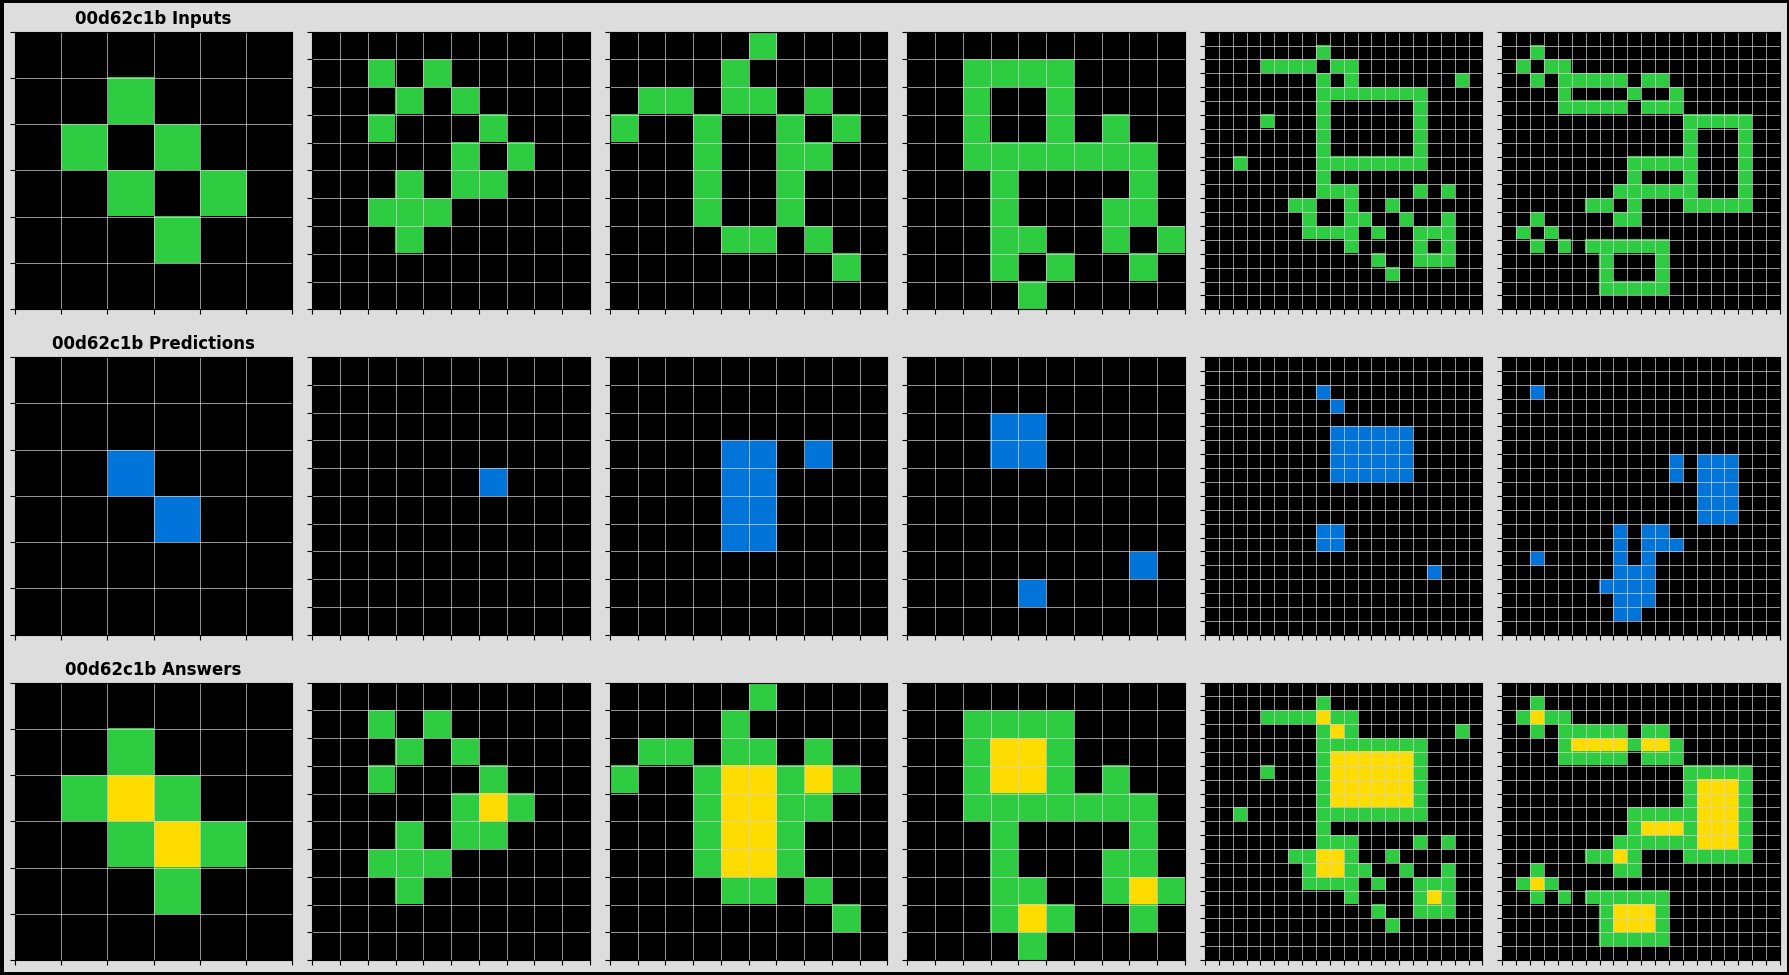

In [9]:
config = load_test_config(ignore_color=True)
test(config)

# Step 2: Consider pixel colors as well

## 2-1. Predict pixels to be kept

In [10]:
class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, feature_dim=1, color_dim=1, **kwargs):
        super().__init__()
        self.color_vector = nn.Parameter(torch.randn(num_classes, feature_dim)) # dim-1 because the first channel is the input

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )

        self.decoder = nn.Sequential(
            nn.Linear(color_dim, 1, bias=False),
        )

    def forward(self, x, **kwargs):
        N, C, H, W = x.shape

        y = self.color_vector.repeat(N*H*W, 1, 1) # [N*H*W, C, V]
        V = y.shape[2]
        y = y.transpose(2, 1) # [N*H*W, V, C]

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C) # [N*H*W, V, C]
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 10
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=False)
    )
  )
  (loss_fn_source): CrossEntropyLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │    861 │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 861                                                                                              
Non-trainable params: 0                                                                                            
Total params: 861                                                                                                  
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 13.585407 | N Pixels Wrong: 5672

Epoch 2 | Train loss: 10.638007 | N Pixels Wrong: 5433

Epoch 3 | Train loss: 8.870575 | N Pixels Wrong: 2402

Epoch 4 | Train loss: 7.697384 | N Pixels Wrong: 1996

Epoch 5 | Train loss: 6.895533 | N Pixels Wrong: 1840

Epoch 6 | Train loss: 6.227042 | N Pixels Wrong: 1784

Epoch 7 | Train loss: 5.552043 | N Pixels Wrong: 1732

Epoch 8 | Train loss: 4.645507 | N Pixels Wrong: 1342

Epoch 9 | Train loss: 3.929290 | N Pixels Wrong: 961

Epoch 10 | Train loss: 3.286510 | N Pixels Wrong: 788

Seed used 11916189748525799534

Model saved to: ./output/FillerKeepInput.ckpt

Task: 00d62c1b | train 1 |  94.44% correct | 2 Pixels Wrong

Task: 00d62c1b | train 2 |  99.00% correct | 1 Pixels Wrong

Task: 00d62c1b | train 3 |  91.00% correct | 9 Pixels Wrong

Task: 00d62c1b | train 4 |  94.00% correct | 6 Pixels Wrong

Task: 00d62c1b | train 5 |  92.25% correct | 31 Pixels Wrong

Task: 00d62c1b |  test 1 |  91.75% correct | 33 Pixels Wrong

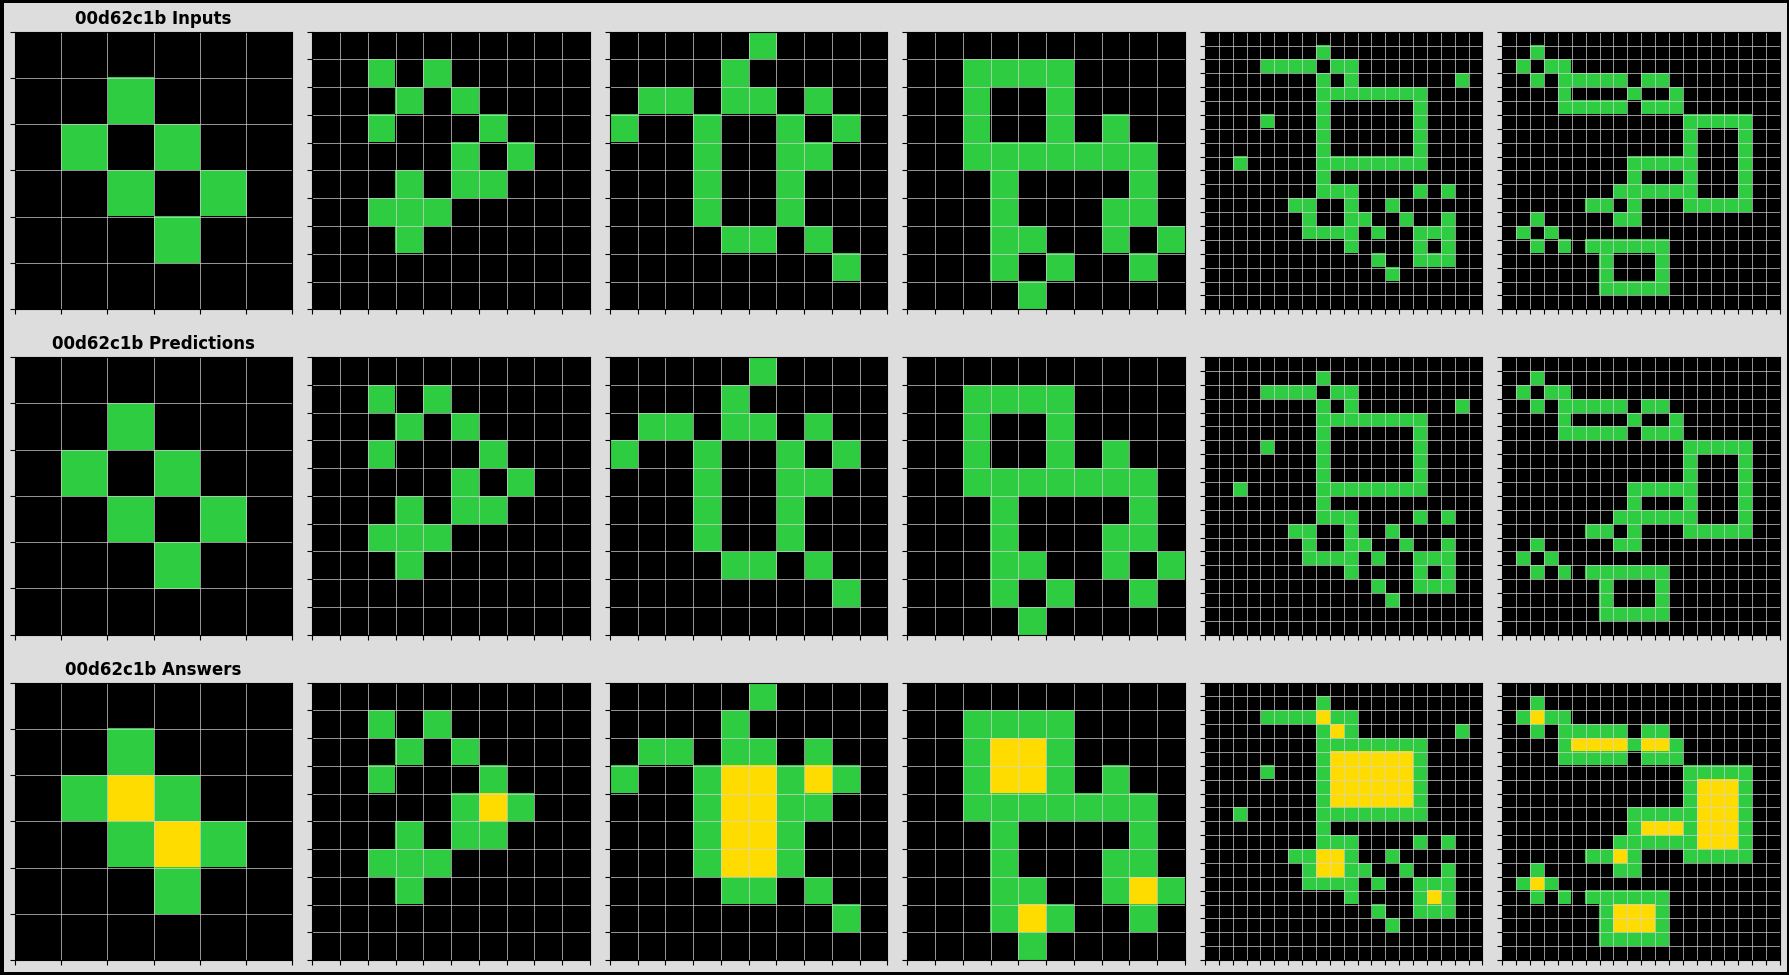

In [11]:
config = load_train_config()
config.train.params.max_epochs = 10
model = train(config, FillerKeepInput, test=True) # Apply custom model

## 2-2. Predict which pixels to be kept and replaced by which color

### Fast Version with Simple Attention over Recurrence of Convolution Layer's Output

In [12]:
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch08/attention_seq2seq.py

class AttentionWeight(nn.Module):
    def __init__(self):
        super(AttentionWeight, self).__init__()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        # Expanding h to match hs's dimensions for batch-wise multiplication
        hr = h.unsqueeze(1)  # shape: batch_size x 1 x hidden_dim
        t = hs * hr
        s = torch.sum(t, dim=2)  # Sum across hidden_dim
        a = F.softmax(s, dim=1)  # Apply softmax across seq_len
        return a

class WeightSum(nn.Module):
    def __init__(self):
        super(WeightSum, self).__init__()

    def forward(self, hs, a):
        # hs: batch_size x seq_len x hidden_dim
        # a: batch_size x seq_len
        # Need to expand a for element-wise multiplication
        ar = a.unsqueeze(2)  # shape: batch_size x seq_len x 1
        t = hs * ar
        c = torch.sum(t, dim=1)  # Sum across seq_len
        return c

class ReductiveAttention(nn.Module):
    def __init__(self):
        super(ReductiveAttention, self).__init__()
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        a = self.attention_weight_layer(hs, h)
        out = self.weight_sum_layer(hs, a)
        return out

In [13]:
from arc_prize.model.components.convfixedkernel import Conv2dEncoderLayer


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[512, 32], hidden_dim=16, out_dim=4):
        super().__init__()
        self.out_dim = out_dim
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(self.V))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.V, out_dim, bias=True),
        )

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1,  self.out_dim, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]

            features_time = []
            features_time.append(x_c.unsqueeze(0))

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]
                features_time.append(x_c.unsqueeze(0))
            features_time = torch.cat(features_time) # [S, N, V, H, W]

            S, N, V, H, W = features_time.shape
            features_time = features_time.permute(1, 3, 4, 0, 2).reshape(N*H*W, S, V)
            feature = self.attn_reduction(features_time, self.attn_h.repeat(N*H*W, 1))

            x_c = self.decoder(feature)  # [N*H*W, V]
            x_c = x_c.view(N, H, W, self.out_dim).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, d_conv_feature=16, d_color_feature=32):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder, out_dim=d_conv_feature)

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )

        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        V = y.shape[2]
        feature = feature.transpose(2, 1) 

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 50
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_feature): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=False)
    )
  )
  (loss_fn_source): CrossEntropyLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │ 34.5 K │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 29.4 K                                                                                           
Non-trainable params: 5.1 K                                                                                        
Total params: 34.5 K                                                                                               
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 6.498108 | N Pixels Wrong: 1744

Epoch 2 | Train loss: 3.556491 | N Pixels Wrong: 1154

Epoch 3 | Train loss: 2.205221 | N Pixels Wrong: 604

Epoch 4 | Train loss: 1.406001 | N Pixels Wrong: 398

Epoch 5 | Train loss: 0.996917 | N Pixels Wrong: 390

Epoch 6 | Train loss: 0.851613 | N Pixels Wrong: 385

Epoch 7 | Train loss: 0.735632 | N Pixels Wrong: 435

Epoch 8 | Train loss: 0.601977 | N Pixels Wrong: 387

Epoch 9 | Train loss: 0.759782 | N Pixels Wrong: 484

Epoch 10 | Train loss: 0.659888 | N Pixels Wrong: 352

Epoch 11 | Train loss: 0.580469 | N Pixels Wrong: 320

Epoch 12 | Train loss: 0.585142 | N Pixels Wrong: 305

Epoch 13 | Train loss: 0.511599 | N Pixels Wrong: 286

Epoch 14 | Train loss: 0.466242 | N Pixels Wrong: 279

Epoch 15 | Train loss: 0.423456 | N Pixels Wrong: 258

Epoch 16 | Train loss: 0.369318 | N Pixels Wrong: 247

Epoch 17 | Train loss: 0.342313 | N Pixels Wrong: 235

Epoch 18 | Train loss: 0.291404 | N Pixels Wrong: 216

Epoch 19 | Train loss: 0.304783 | N Pixels Wrong: 217

Epoch 20 | Train loss: 0.229827 | N Pixels Wrong: 197

Epoch 21 | Train loss: 0.238046 | N Pixels Wrong: 194

Epoch 22 | Train loss: 0.175035 | N Pixels Wrong: 174

Epoch 23 | Train loss: 0.176465 | N Pixels Wrong: 150

Epoch 24 | Train loss: 0.184070 | N Pixels Wrong: 142

Epoch 25 | Train loss: 0.167733 | N Pixels Wrong: 203

Epoch 26 | Train loss: 0.201800 | N Pixels Wrong: 138

Epoch 27 | Train loss: 0.213415 | N Pixels Wrong: 148

Epoch 28 | Train loss: 0.164248 | N Pixels Wrong: 116

Epoch 29 | Train loss: 0.143097 | N Pixels Wrong: 111

Epoch 30 | Train loss: 0.123481 | N Pixels Wrong: 109

Epoch 31 | Train loss: 0.115773 | N Pixels Wrong: 102

Epoch 32 | Train loss: 0.101671 | N Pixels Wrong: 99

Epoch 33 | Train loss: 0.090490 | N Pixels Wrong: 93

Epoch 34 | Train loss: 0.085413 | N Pixels Wrong: 82

Epoch 35 | Train loss: 0.105817 | N Pixels Wrong: 108

Epoch 36 | Train loss: 0.084103 | N Pixels Wrong: 86

Epoch 37 | Train loss: 0.093237 | N Pixels Wrong: 89

Epoch 38 | Train loss: 0.092560 | N Pixels Wrong: 77

Epoch 39 | Train loss: 0.093868 | N Pixels Wrong: 76

Epoch 40 | Train loss: 0.089316 | N Pixels Wrong: 85

Epoch 41 | Train loss: 0.104274 | N Pixels Wrong: 117

Epoch 42 | Train loss: 0.080090 | N Pixels Wrong: 84

Epoch 43 | Train loss: 0.062130 | N Pixels Wrong: 69

Epoch 44 | Train loss: 0.050532 | N Pixels Wrong: 56

Epoch 45 | Train loss: 0.042868 | N Pixels Wrong: 44

Epoch 46 | Train loss: 0.039653 | N Pixels Wrong: 50

Epoch 47 | Train loss: 0.034884 | N Pixels Wrong: 35

Epoch 48 | Train loss: 0.040550 | N Pixels Wrong: 38

Epoch 49 | Train loss: 0.063603 | N Pixels Wrong: 65

Epoch 50 | Train loss: 0.053197 | N Pixels Wrong: 59

Seed used 12960308362502693925

Model saved to: ./output/FillerKeepInput.ckpt

Task: 00d62c1b | train 1 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 2 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 3 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 4 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 5 |  99.50% correct | 2 Pixels Wrong

Task: 00d62c1b |  test 1 |  96.50% correct | 14 Pixels Wrong

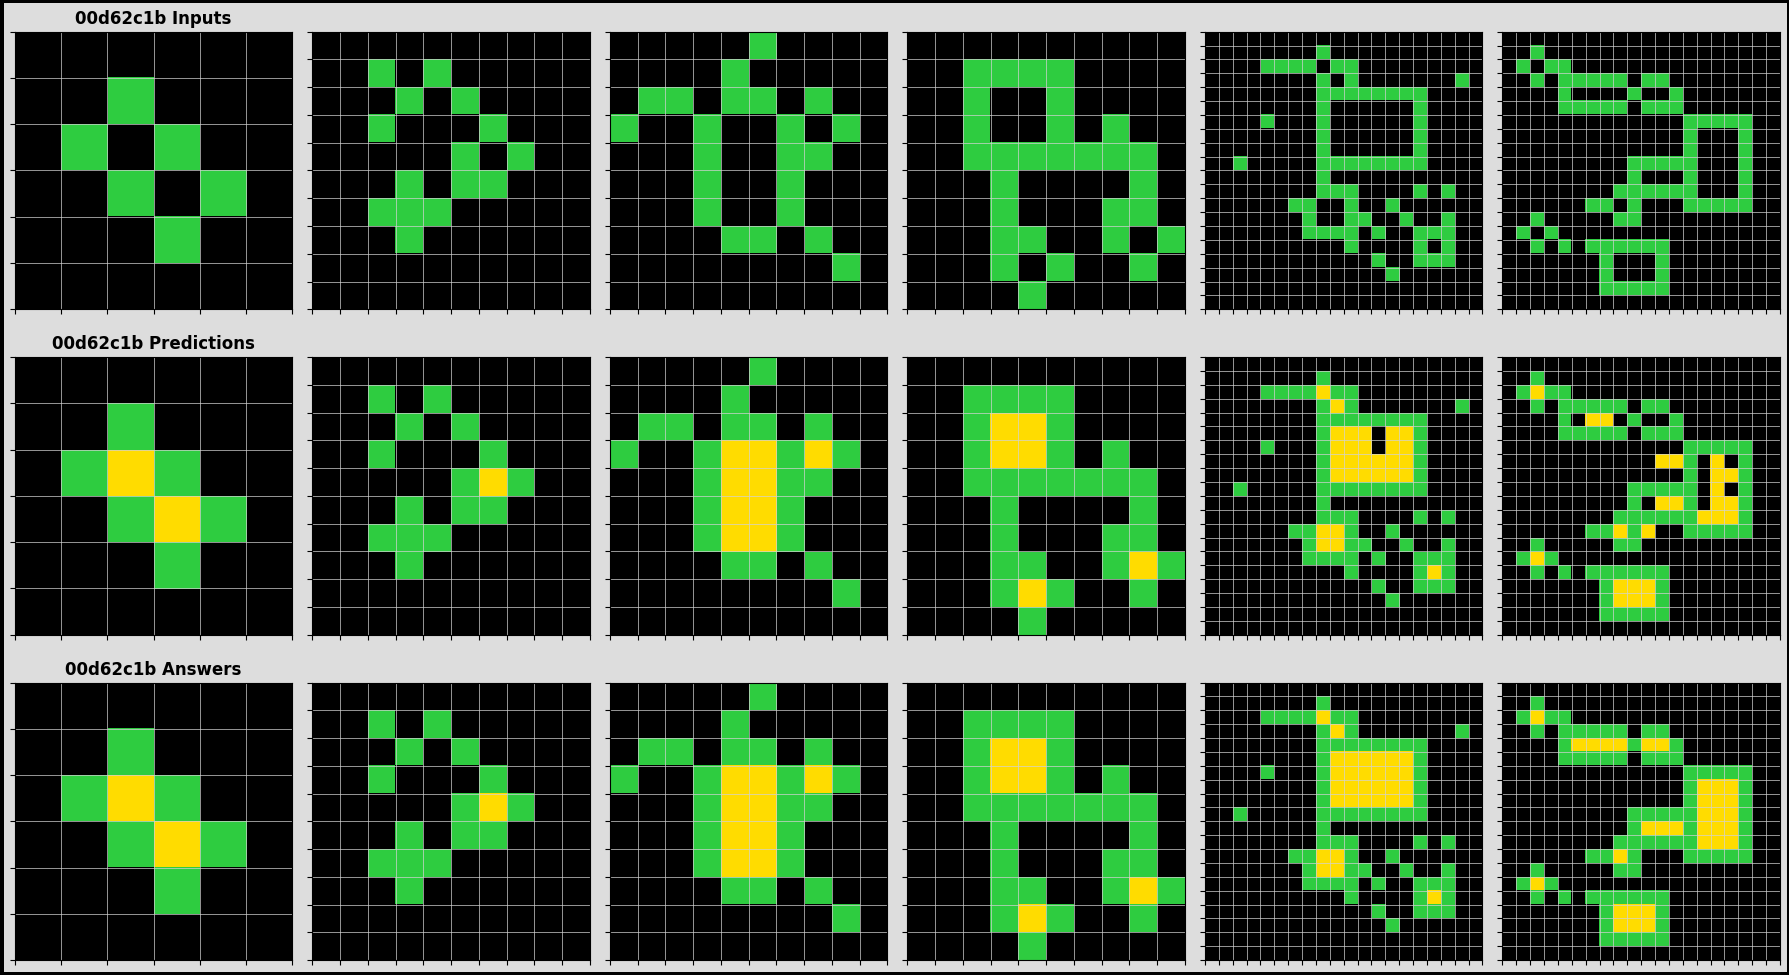

In [14]:
config = load_train_config()
config.train.params.max_epochs = 50
train(config, FillerKeepInput, test=True)

### Slow Version with Attentions in Each Recurrence of Convolution Layer's Output

In [15]:
config = load_train_config()
train(config)

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 250
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder_initial): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=False)
      )
      (attn_conv): TransformerDecoder(
        (layers): ModuleList(
          (0): TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (multihead_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (linear1): Linear(in_features=32, out_features=1, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1, out_features=32, bias=True)
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
            (dropout3): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder_secondary_feature): Sequential(
        (0): Linear(in_features=32, out_features=1, bias=False)
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_feature): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerN

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │ 43.7 K │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 38.6 K                                                                                           
Non-trainable params: 5.1 K                                                                                        
Total params: 43.7 K                                                                                               
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 10.393021 | N Pixels Wrong: 2300

Epoch 2 | Train loss: 5.560037 | N Pixels Wrong: 1456

Epoch 3 | Train loss: 4.075932 | N Pixels Wrong: 1426

Epoch 4 | Train loss: 2.558752 | N Pixels Wrong: 1187

Epoch 5 | Train loss: 1.570544 | N Pixels Wrong: 514

Epoch 6 | Train loss: 1.069278 | N Pixels Wrong: 403

Epoch 7 | Train loss: 0.837851 | N Pixels Wrong: 382

Epoch 8 | Train loss: 0.727274 | N Pixels Wrong: 422

Epoch 9 | Train loss: 0.569975 | N Pixels Wrong: 334

Epoch 10 | Train loss: 0.593472 | N Pixels Wrong: 300

Epoch 11 | Train loss: 0.530804 | N Pixels Wrong: 284

Epoch 12 | Train loss: 0.513809 | N Pixels Wrong: 287

Epoch 13 | Train loss: 0.458420 | N Pixels Wrong: 218

Epoch 14 | Train loss: 0.391062 | N Pixels Wrong: 193

Epoch 15 | Train loss: 0.349980 | N Pixels Wrong: 208

Epoch 16 | Train loss: 0.475626 | N Pixels Wrong: 244

Epoch 17 | Train loss: 0.613164 | N Pixels Wrong: 401

Epoch 18 | Train loss: 0.526657 | N Pixels Wrong: 335

Epoch 19 | Train loss: 0.394668 | N Pixels Wrong: 233

Epoch 20 | Train loss: 0.356501 | N Pixels Wrong: 214

Epoch 21 | Train loss: 0.315104 | N Pixels Wrong: 155

Epoch 22 | Train loss: 0.284493 | N Pixels Wrong: 155

Epoch 23 | Train loss: 0.320532 | N Pixels Wrong: 210

Epoch 24 | Train loss: 0.314018 | N Pixels Wrong: 217

Epoch 25 | Train loss: 0.333179 | N Pixels Wrong: 183

Epoch 26 | Train loss: 0.274214 | N Pixels Wrong: 203

Epoch 27 | Train loss: 0.216003 | N Pixels Wrong: 140

Epoch 28 | Train loss: 0.176521 | N Pixels Wrong: 129

Epoch 29 | Train loss: 0.187498 | N Pixels Wrong: 159

Epoch 30 | Train loss: 0.236135 | N Pixels Wrong: 161

Epoch 31 | Train loss: 0.331526 | N Pixels Wrong: 288

Epoch 32 | Train loss: 0.147486 | N Pixels Wrong: 101

Epoch 33 | Train loss: 0.150275 | N Pixels Wrong: 92

Epoch 34 | Train loss: 0.104199 | N Pixels Wrong: 88

Epoch 35 | Train loss: 0.053955 | N Pixels Wrong: 42

Epoch 36 | Train loss: 0.076596 | N Pixels Wrong: 70

Epoch 37 | Train loss: 0.075641 | N Pixels Wrong: 47

Epoch 38 | Train loss: 0.053339 | N Pixels Wrong: 43

Epoch 39 | Train loss: 0.035185 | N Pixels Wrong: 28

Epoch 40 | Train loss: 0.038483 | N Pixels Wrong: 29

Epoch 41 | Train loss: 0.017975 | N Pixels Wrong: 11

Epoch 42 | Train loss: 0.012764 | N Pixels Wrong: 7

Epoch 43 | Train loss: 0.012056 | N Pixels Wrong: 8

Epoch 44 | Train loss: 0.018671 | N Pixels Wrong: 14

Epoch 45 | Train loss: 0.045675 | N Pixels Wrong: 31

Epoch 46 | Train loss: 0.010404 | N Pixels Wrong: 7

Epoch 47 | Train loss: 0.143970 | N Pixels Wrong: 91

Epoch 48 | Train loss: 0.305876 | N Pixels Wrong: 193

Epoch 49 | Train loss: 0.416690 | N Pixels Wrong: 284

Epoch 50 | Train loss: 0.201556 | N Pixels Wrong: 147

Epoch 51 | Train loss: 0.190526 | N Pixels Wrong: 117

Epoch 52 | Train loss: 0.132993 | N Pixels Wrong: 85

Epoch 53 | Train loss: 0.076614 | N Pixels Wrong: 48

Epoch 54 | Train loss: 0.113669 | N Pixels Wrong: 82

Epoch 55 | Train loss: 0.127840 | N Pixels Wrong: 97

Epoch 56 | Train loss: 0.110754 | N Pixels Wrong: 65

Epoch 57 | Train loss: 0.103336 | N Pixels Wrong: 103

Epoch 58 | Train loss: 0.120379 | N Pixels Wrong: 85

Epoch 59 | Train loss: 0.109655 | N Pixels Wrong: 100

Epoch 60 | Train loss: 0.060471 | N Pixels Wrong: 55

Epoch 61 | Train loss: 0.035195 | N Pixels Wrong: 30

Epoch 62 | Train loss: 0.026385 | N Pixels Wrong: 17

Epoch 63 | Train loss: 0.017280 | N Pixels Wrong: 15

Epoch 64 | Train loss: 0.024512 | N Pixels Wrong: 18

Epoch 65 | Train loss: 0.013257 | N Pixels Wrong: 11

Epoch 66 | Train loss: 0.010988 | N Pixels Wrong: 12

Epoch 67 | Train loss: 0.007120 | N Pixels Wrong: 6

Epoch 68 | Train loss: 0.007535 | N Pixels Wrong: 6

Epoch 69 | Train loss: 0.007863 | N Pixels Wrong: 6

Epoch 70 | Train loss: 0.003625 | N Pixels Wrong: 2

Epoch 71 | Train loss: 0.004085 | N Pixels Wrong: 2

Epoch 72 | Train loss: 0.007022 | N Pixels Wrong: 6

Epoch 73 | Train loss: 0.005795 | N Pixels Wrong: 4

Epoch 74 | Train loss: 0.005156 | N Pixels Wrong: 4

Epoch 75 | Train loss: 0.004434 | N Pixels Wrong: 3

Epoch 76 | Train loss: 0.003867 | N Pixels Wrong: 3

Epoch 77 | Train loss: 0.003321 | N Pixels Wrong: 2

Epoch 78 | Train loss: 0.002939 | N Pixels Wrong: 1

Epoch 79 | Train loss: 0.002500 | N Pixels Wrong: 1

Epoch 80 | Train loss: 0.002812 | N Pixels Wrong: 1

Epoch 81 | Train loss: 0.002383 | N Pixels Wrong: 1

Epoch 82 | Train loss: 0.002153 | N Pixels Wrong: 1

Epoch 83 | Train loss: 0.001952 | N Pixels Wrong: 1

Epoch 84 | Train loss: 0.002194 | N Pixels Wrong: 1

Epoch 85 | Train loss: 0.001679 | N Pixels Wrong: 1

Epoch 86 | Train loss: 0.001720 | N Pixels Wrong: 1

Epoch 87 | Train loss: 0.002162 | N Pixels Wrong: 1

Epoch 88 | Train loss: 0.001349 | N Pixels Wrong: 1

Epoch 89 | Train loss: 0.001256 | N Pixels Wrong: 1

Epoch 90 | Train loss: 0.001621 | N Pixels Wrong: 1

Epoch 91 | Train loss: 0.001078 | N Pixels Wrong: 0

Epoch 92 | Train loss: 0.001077 | N Pixels Wrong: 1

Epoch 93 | Train loss: 0.001062 | N Pixels Wrong: 1

Epoch 94 | Train loss: 0.001065 | N Pixels Wrong: 0

Epoch 95 | Train loss: 0.000793 | N Pixels Wrong: 0

Epoch 96 | Train loss: 0.000977 | N Pixels Wrong: 1

Epoch 97 | Train loss: 0.001096 | N Pixels Wrong: 1

Epoch 98 | Train loss: 0.000785 | N Pixels Wrong: 0

Epoch 99 | Train loss: 0.000579 | N Pixels Wrong: 0

Epoch 100 | Train loss: 0.000555 | N Pixels Wrong: 0

Epoch 101 | Train loss: 0.000618 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInput_101ep.ckpt

Epoch 102 | Train loss: 0.000623 | N Pixels Wrong: 0

Epoch 103 | Train loss: 0.000541 | N Pixels Wrong: 0

Epoch 104 | Train loss: 0.000596 | N Pixels Wrong: 0

Epoch 105 | Train loss: 0.000433 | N Pixels Wrong: 0

Epoch 106 | Train loss: 0.000504 | N Pixels Wrong: 0

Epoch 107 | Train loss: 0.000524 | N Pixels Wrong: 0

Epoch 108 | Train loss: 0.000458 | N Pixels Wrong: 0

Epoch 109 | Train loss: 0.000470 | N Pixels Wrong: 0

Epoch 110 | Train loss: 0.000440 | N Pixels Wrong: 0

Epoch 111 | Train loss: 0.000506 | N Pixels Wrong: 0

Epoch 112 | Train loss: 0.000424 | N Pixels Wrong: 0

Epoch 113 | Train loss: 0.000353 | N Pixels Wrong: 0

Epoch 114 | Train loss: 0.000405 | N Pixels Wrong: 0

Epoch 115 | Train loss: 0.000408 | N Pixels Wrong: 0

Epoch 116 | Train loss: 0.000387 | N Pixels Wrong: 0

Epoch 117 | Train loss: 0.000419 | N Pixels Wrong: 0

Epoch 118 | Train loss: 0.000368 | N Pixels Wrong: 0

Epoch 119 | Train loss: 0.000336 | N Pixels Wrong: 0

Epoch 120 | Train loss: 0.000307 | N Pixels Wrong: 0

Epoch 121 | Train loss: 0.000321 | N Pixels Wrong: 0

Epoch 122 | Train loss: 0.000333 | N Pixels Wrong: 0

Epoch 123 | Train loss: 0.000335 | N Pixels Wrong: 0

Epoch 124 | Train loss: 0.000310 | N Pixels Wrong: 0

Epoch 125 | Train loss: 0.000677 | N Pixels Wrong: 0

Epoch 126 | Train loss: 0.000263 | N Pixels Wrong: 0

Epoch 127 | Train loss: 0.000256 | N Pixels Wrong: 0

Epoch 128 | Train loss: 0.000252 | N Pixels Wrong: 0

Epoch 129 | Train loss: 0.000260 | N Pixels Wrong: 0

Epoch 130 | Train loss: 0.000265 | N Pixels Wrong: 0

Epoch 131 | Train loss: 0.000238 | N Pixels Wrong: 0

Epoch 132 | Train loss: 0.000287 | N Pixels Wrong: 0

Epoch 133 | Train loss: 0.000269 | N Pixels Wrong: 0

Epoch 134 | Train loss: 0.000234 | N Pixels Wrong: 0

Epoch 135 | Train loss: 0.000239 | N Pixels Wrong: 0

Epoch 136 | Train loss: 0.000258 | N Pixels Wrong: 0

Epoch 137 | Train loss: 0.000227 | N Pixels Wrong: 0

Epoch 138 | Train loss: 0.000263 | N Pixels Wrong: 0

Epoch 139 | Train loss: 0.000217 | N Pixels Wrong: 0

Epoch 140 | Train loss: 0.000245 | N Pixels Wrong: 0

Epoch 141 | Train loss: 0.000221 | N Pixels Wrong: 0

Epoch 142 | Train loss: 0.000417 | N Pixels Wrong: 0

Epoch 143 | Train loss: 0.000257 | N Pixels Wrong: 0

Epoch 144 | Train loss: 0.000230 | N Pixels Wrong: 0

Epoch 145 | Train loss: 0.000233 | N Pixels Wrong: 0

Epoch 146 | Train loss: 0.000232 | N Pixels Wrong: 0

Epoch 147 | Train loss: 0.000189 | N Pixels Wrong: 0

Epoch 148 | Train loss: 0.000204 | N Pixels Wrong: 0

Epoch 149 | Train loss: 0.000187 | N Pixels Wrong: 0

Epoch 150 | Train loss: 0.000184 | N Pixels Wrong: 0

Epoch 151 | Train loss: 0.000184 | N Pixels Wrong: 0

Epoch 152 | Train loss: 0.000167 | N Pixels Wrong: 0

Epoch 153 | Train loss: 0.000170 | N Pixels Wrong: 0

Epoch 154 | Train loss: 0.000203 | N Pixels Wrong: 0

Epoch 155 | Train loss: 0.000163 | N Pixels Wrong: 0

Epoch 156 | Train loss: 0.000182 | N Pixels Wrong: 0

Epoch 157 | Train loss: 0.000177 | N Pixels Wrong: 0

Epoch 158 | Train loss: 0.000158 | N Pixels Wrong: 0

Epoch 159 | Train loss: 0.000160 | N Pixels Wrong: 0

Epoch 160 | Train loss: 0.000185 | N Pixels Wrong: 0

Epoch 161 | Train loss: 0.000155 | N Pixels Wrong: 0

Epoch 162 | Train loss: 0.000162 | N Pixels Wrong: 0

Epoch 163 | Train loss: 0.000162 | N Pixels Wrong: 0

Epoch 164 | Train loss: 0.000154 | N Pixels Wrong: 0

Epoch 165 | Train loss: 0.000192 | N Pixels Wrong: 0

Epoch 166 | Train loss: 0.000176 | N Pixels Wrong: 0

Epoch 167 | Train loss: 0.000145 | N Pixels Wrong: 0

Epoch 168 | Train loss: 0.000149 | N Pixels Wrong: 0

Epoch 169 | Train loss: 0.000139 | N Pixels Wrong: 0

Epoch 170 | Train loss: 0.000144 | N Pixels Wrong: 0

Epoch 171 | Train loss: 0.000166 | N Pixels Wrong: 0

Epoch 172 | Train loss: 0.000128 | N Pixels Wrong: 0

Epoch 173 | Train loss: 0.000135 | N Pixels Wrong: 0

Epoch 174 | Train loss: 0.000132 | N Pixels Wrong: 0

Epoch 175 | Train loss: 0.000149 | N Pixels Wrong: 0

Epoch 176 | Train loss: 0.000136 | N Pixels Wrong: 0

Epoch 177 | Train loss: 0.000204 | N Pixels Wrong: 0

Epoch 178 | Train loss: 0.000134 | N Pixels Wrong: 0

Epoch 179 | Train loss: 0.000123 | N Pixels Wrong: 0

Epoch 180 | Train loss: 0.000135 | N Pixels Wrong: 0

Epoch 181 | Train loss: 0.000134 | N Pixels Wrong: 0

Epoch 182 | Train loss: 0.000118 | N Pixels Wrong: 0

Epoch 183 | Train loss: 0.000134 | N Pixels Wrong: 0

Epoch 184 | Train loss: 0.000110 | N Pixels Wrong: 0

Epoch 185 | Train loss: 0.000115 | N Pixels Wrong: 0

Epoch 186 | Train loss: 0.000120 | N Pixels Wrong: 0

Epoch 187 | Train loss: 0.000105 | N Pixels Wrong: 0

Epoch 188 | Train loss: 0.000106 | N Pixels Wrong: 0

Epoch 189 | Train loss: 0.000193 | N Pixels Wrong: 0

Epoch 190 | Train loss: 0.000102 | N Pixels Wrong: 0

Epoch 191 | Train loss: 0.000106 | N Pixels Wrong: 0

Epoch 192 | Train loss: 0.000112 | N Pixels Wrong: 0

Epoch 193 | Train loss: 0.000090 | N Pixels Wrong: 0

Epoch 194 | Train loss: 0.000133 | N Pixels Wrong: 0

Epoch 195 | Train loss: 0.000103 | N Pixels Wrong: 0

Epoch 196 | Train loss: 0.000125 | N Pixels Wrong: 0

Epoch 197 | Train loss: 0.000120 | N Pixels Wrong: 0

Epoch 198 | Train loss: 0.000131 | N Pixels Wrong: 0

Epoch 199 | Train loss: 0.000098 | N Pixels Wrong: 0

Epoch 200 | Train loss: 0.000102 | N Pixels Wrong: 0

Epoch 201 | Train loss: 0.000092 | N Pixels Wrong: 0

Epoch 202 | Train loss: 0.000131 | N Pixels Wrong: 0

Epoch 203 | Train loss: 0.000139 | N Pixels Wrong: 0

Epoch 204 | Train loss: 0.000130 | N Pixels Wrong: 0

Epoch 205 | Train loss: 0.000094 | N Pixels Wrong: 0

Epoch 206 | Train loss: 0.000106 | N Pixels Wrong: 0

Epoch 207 | Train loss: 0.000099 | N Pixels Wrong: 0

Epoch 208 | Train loss: 0.000098 | N Pixels Wrong: 0

Epoch 209 | Train loss: 0.000091 | N Pixels Wrong: 0

Epoch 210 | Train loss: 0.000080 | N Pixels Wrong: 0

Epoch 211 | Train loss: 0.000096 | N Pixels Wrong: 0

Epoch 212 | Train loss: 0.000096 | N Pixels Wrong: 0

Epoch 213 | Train loss: 0.000104 | N Pixels Wrong: 0

Epoch 214 | Train loss: 0.000091 | N Pixels Wrong: 0

Epoch 215 | Train loss: 0.000104 | N Pixels Wrong: 0

Epoch 216 | Train loss: 0.000081 | N Pixels Wrong: 0

Epoch 217 | Train loss: 0.000083 | N Pixels Wrong: 0

Epoch 218 | Train loss: 0.000091 | N Pixels Wrong: 0

Epoch 219 | Train loss: 0.000096 | N Pixels Wrong: 0

Epoch 220 | Train loss: 0.000078 | N Pixels Wrong: 0

Epoch 221 | Train loss: 0.000075 | N Pixels Wrong: 0

Epoch 222 | Train loss: 0.000071 | N Pixels Wrong: 0

Epoch 223 | Train loss: 0.000074 | N Pixels Wrong: 0

Epoch 224 | Train loss: 0.000076 | N Pixels Wrong: 0

Epoch 225 | Train loss: 0.000078 | N Pixels Wrong: 0

Epoch 226 | Train loss: 0.000105 | N Pixels Wrong: 0

Epoch 227 | Train loss: 0.000078 | N Pixels Wrong: 0

Epoch 228 | Train loss: 0.000075 | N Pixels Wrong: 0

Epoch 229 | Train loss: 0.000072 | N Pixels Wrong: 0

Epoch 230 | Train loss: 0.000085 | N Pixels Wrong: 0

Epoch 231 | Train loss: 0.000087 | N Pixels Wrong: 0

Epoch 232 | Train loss: 0.000076 | N Pixels Wrong: 0

Epoch 233 | Train loss: 0.000064 | N Pixels Wrong: 0

Epoch 234 | Train loss: 0.000083 | N Pixels Wrong: 0

Epoch 235 | Train loss: 0.000074 | N Pixels Wrong: 0

Epoch 236 | Train loss: 0.000065 | N Pixels Wrong: 0

Epoch 237 | Train loss: 0.000075 | N Pixels Wrong: 0

Epoch 238 | Train loss: 0.000077 | N Pixels Wrong: 0

Epoch 239 | Train loss: 0.000061 | N Pixels Wrong: 0

Epoch 240 | Train loss: 0.000063 | N Pixels Wrong: 0

Epoch 241 | Train loss: 0.000076 | N Pixels Wrong: 0

Epoch 242 | Train loss: 0.000081 | N Pixels Wrong: 0

Epoch 243 | Train loss: 0.000071 | N Pixels Wrong: 0

Epoch 244 | Train loss: 0.000067 | N Pixels Wrong: 0

Epoch 245 | Train loss: 0.000058 | N Pixels Wrong: 0

Epoch 246 | Train loss: 0.000064 | N Pixels Wrong: 0

Epoch 247 | Train loss: 0.000071 | N Pixels Wrong: 0

Epoch 248 | Train loss: 0.000055 | N Pixels Wrong: 0

Epoch 249 | Train loss: 0.000060 | N Pixels Wrong: 0

Epoch 250 | Train loss: 0.000064 | N Pixels Wrong: 0

Seed used 13511808293250617550

Model saved to: ./output/FillerKeepInput.ckpt

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null

Task: 00d62c1b | train 1 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 2 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 3 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 4 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 5 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b |  test 1 |  97.25% correct | 11 Pixels Wrong

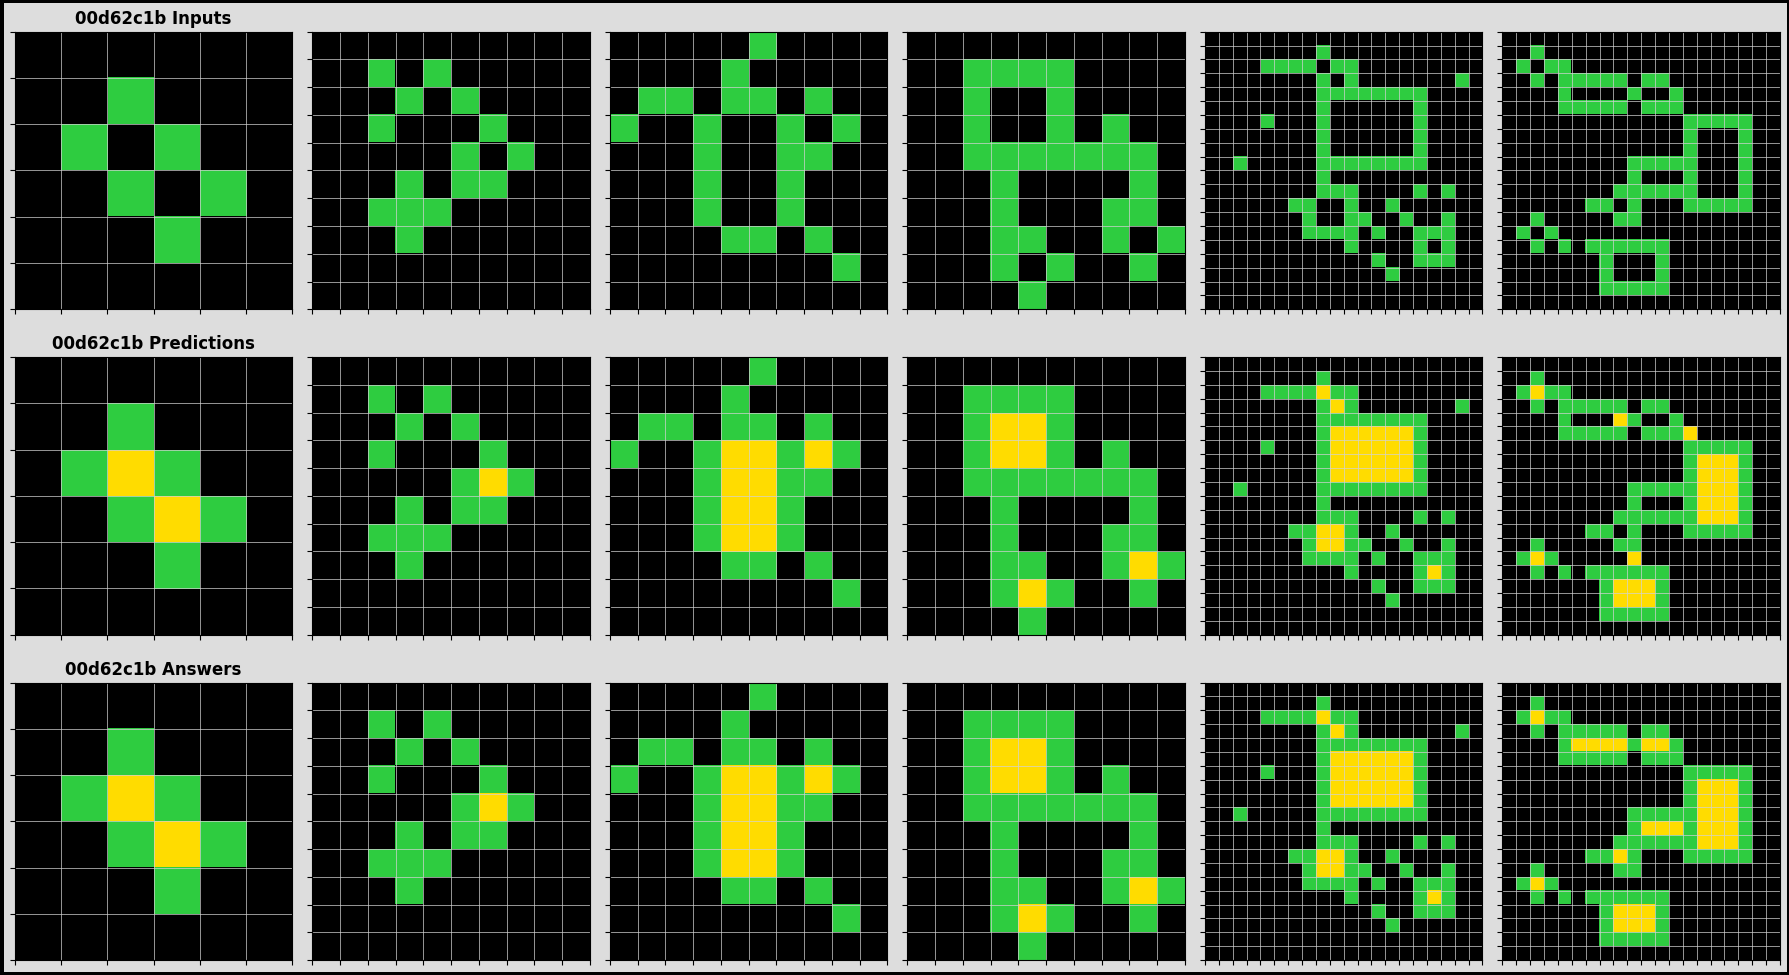

In [16]:
config = load_test_config()
test(config)

# Step 3: Customize the model

## Source Code of the Latest Model

In [17]:
from itertools import product
from torch.nn.modules.conv import _size_2_t, Union


class Conv2dFixedKernel(nn.Conv2d):
    def __init__(
        self, 
        in_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = False,
        padding_mode: str = 'zeros',
        device=None,
        dtype=None,
        weight=None, 
        update=False
    ):
        if weight is None:
            weight, out_channels, biases = self.generate_all_possible_NxM_kernels(kernel_size, device=device, dtype=dtype)
        else:
            out_channels = weight.shape[0]
            biases = self.generate_biases(weight)

        super().__init__(
            in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias, padding_mode, 
            device, dtype
        )

        # Remove the default weight parameter
        del self._parameters['weight']
        del self._parameters['bias']

        # Register weight as a parameter for updates
        param = nn.Parameter(weight, requires_grad=update)
        self.register_parameter('weight', param)
        
        self.bias = nn.Parameter(biases, requires_grad=update)
        self.register_parameter('bias', self.bias)

    @staticmethod
    def generate_all_possible_NxM_kernels(kernel_size=(3, 3), device=None, dtype=None):
        '''Generate all possible n x m kernels with values 0 and 1'''
        weight_values = [0.0, 1.0]
        repeat = kernel_size[0] * kernel_size[1]
        # Generate all possible combinations of kernel values
        weight_custom = torch.cat(
            [torch.tensor(kernel, dtype=dtype, device=device).reshape(1, 1, kernel_size[0], kernel_size[1]) 
             for kernel in product(weight_values, repeat=repeat)], dim=0)

        out_channels = len(weight_values) ** repeat
        
        # Generate corresponding biases
        biases = -(torch.sum(weight_custom, dim=(2, 3)) - 1).reshape(out_channels).to(device=device, dtype=dtype)
        
        return weight_custom, out_channels, biases

    @staticmethod
    def generate_biases(weight):
        '''Generate biases based on weight patterns'''
        return -(torch.sum(weight, dim=(2, 3)) - 1).reshape(weight.shape[0])


class Conv2dEncoderLayer(nn.Module):
    def __init__(self, in_channels=1, reduced_channels=[512, 32], fixed_kernel=False, out_one_channel=False, kernel_size=(3, 3), stride=1, padding=1, pad_value=-1):
        super().__init__()
        self.padding = padding
        self.pad_value = pad_value
        self.fixed_kernel = fixed_kernel

        if fixed_kernel:
            self.conv = Conv2dFixedKernel(in_channels, kernel_size=kernel_size, stride=stride, padding=0)
        else:
            self.conv = nn.Conv2d(in_channels, reduced_channels[0], kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.activation = nn.ReLU()

        self.linear_layers = nn.Sequential()
        for i in range(len(reduced_channels)-1):
            self.linear_layers.add_module(f'linear_{i}', nn.Linear(reduced_channels[i], reduced_channels[i+1], bias=False))
            self.linear_layers.add_module(f'relu_{i}', nn.ReLU())

        if out_one_channel:
            self.linear_layers.add_module('out', nn.Linear(reduced_channels[-1], 1, bias=False))

        self.norm = nn.InstanceNorm2d(reduced_channels[-1] if not out_one_channel else 1)

    def forward(self, x):
        N, H, W = x.shape[0], x.shape[2], x.shape[3]
        if self.fixed_kernel:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=self.pad_value)
        x = self.activation(self.conv(x)) # [N, C, H, W]
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, -1) # [N*H*W, C]
        x = self.linear_layers(x)
        x = x.view(N, H, W, -1).permute(0, 3, 1, 2)
        x = self.norm(x)

        return x

In [18]:
from arc_prize.constants import COLORS


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1):
        super().__init__()
        self.d_conv_feature = d_conv_feature
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=1)
        self.decoder_initial = nn.Sequential(
            nn.Linear(self.V, d_conv_feature, bias=False),
        )

        self.attn_conv = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=self.V, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder_secondary_feature = nn.Sequential(
            nn.Linear(self.V, 1, bias=False),
        )
        self.feature_map = nn.Parameter(torch.randn(d_conv_feature, self.V))

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V2 = self.d_conv_feature
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1, V2, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            V = x_c.shape[1]

            feature = x_c.permute(0, 2, 3, 1).reshape(N*H*W, self.V)
            feature = self.decoder_initial(feature).view(N*H*W, -1, 1).repeat(1, 1, V) # [N*H*W, V2, V]

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]

                feature = self.attn_conv(feature, x_c.permute(0, 2, 3, 1).reshape(N*H*W, 1, V))
            feature = feature.view(N, H, W, V2, V).view(N*H*W*V2, V)

            x_c = self.decoder_secondary_feature(feature) # [N*H*W*V2, 1]
            x_c = x_c.view(N, H, W, -1).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1, d_color_feature=32, num_classes=len(COLORS)):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(reduced_channels_encoder, reduced_channels_decoder, d_conv_feature, pad_value)
        self.d_color_feature = d_color_feature
    
        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )
        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V = self.d_color_feature
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        feature = feature.transpose(2, 1) # [N*H*W, V, C]

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 250
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder_initial): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=False)
      )
      (attn_conv): TransformerDecoder(
        (layers): ModuleList(
          (0): TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (multihead_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (linear1): Linear(in_features=32, out_features=1, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1, out_features=32, bias=True)
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
            (dropout3): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder_secondary_feature): Sequential(
        (0): Linear(in_features=32, out_features=1, bias=False)
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_feature): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerN

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │ 43.7 K │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 38.6 K                                                                                           
Non-trainable params: 5.1 K                                                                                        
Total params: 43.7 K                                                                                               
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 7.532516 | N Pixels Wrong: 4020

Epoch 2 | Train loss: 4.238658 | N Pixels Wrong: 1453

Epoch 3 | Train loss: 2.834766 | N Pixels Wrong: 846

Epoch 4 | Train loss: 1.731793 | N Pixels Wrong: 411

Epoch 5 | Train loss: 1.200196 | N Pixels Wrong: 380

Epoch 6 | Train loss: 1.004254 | N Pixels Wrong: 381

Epoch 7 | Train loss: 0.987182 | N Pixels Wrong: 380

Epoch 8 | Train loss: 0.949341 | N Pixels Wrong: 382

Epoch 9 | Train loss: 0.953585 | N Pixels Wrong: 380

Epoch 10 | Train loss: 0.926998 | N Pixels Wrong: 381

Epoch 11 | Train loss: 0.813524 | N Pixels Wrong: 439

Epoch 12 | Train loss: 0.820769 | N Pixels Wrong: 499

Epoch 13 | Train loss: 0.740328 | N Pixels Wrong: 394

Epoch 14 | Train loss: 0.712486 | N Pixels Wrong: 426

Epoch 15 | Train loss: 0.725547 | N Pixels Wrong: 485

Epoch 16 | Train loss: 0.660153 | N Pixels Wrong: 397

Epoch 17 | Train loss: 0.762966 | N Pixels Wrong: 393

Epoch 18 | Train loss: 0.758120 | N Pixels Wrong: 357

Epoch 19 | Train loss: 0.730512 | N Pixels Wrong: 433

Epoch 20 | Train loss: 0.881805 | N Pixels Wrong: 389

Epoch 21 | Train loss: 0.808872 | N Pixels Wrong: 385

Epoch 22 | Train loss: 0.822444 | N Pixels Wrong: 376

Epoch 23 | Train loss: 0.733377 | N Pixels Wrong: 358

Epoch 24 | Train loss: 0.753205 | N Pixels Wrong: 419

Epoch 25 | Train loss: 0.721348 | N Pixels Wrong: 368

Epoch 26 | Train loss: 0.719376 | N Pixels Wrong: 393

Epoch 27 | Train loss: 0.712857 | N Pixels Wrong: 370

Epoch 28 | Train loss: 0.668660 | N Pixels Wrong: 374

Epoch 29 | Train loss: 0.649830 | N Pixels Wrong: 361

Epoch 30 | Train loss: 0.578578 | N Pixels Wrong: 318

Epoch 31 | Train loss: 0.566363 | N Pixels Wrong: 317

Epoch 32 | Train loss: 0.555149 | N Pixels Wrong: 319

Epoch 33 | Train loss: 0.535182 | N Pixels Wrong: 298

Epoch 34 | Train loss: 0.531041 | N Pixels Wrong: 281

Epoch 35 | Train loss: 0.508793 | N Pixels Wrong: 275

Epoch 36 | Train loss: 0.510793 | N Pixels Wrong: 273

Epoch 37 | Train loss: 0.497870 | N Pixels Wrong: 274

Epoch 38 | Train loss: 0.504616 | N Pixels Wrong: 258

Epoch 39 | Train loss: 0.497372 | N Pixels Wrong: 244

Epoch 40 | Train loss: 0.476088 | N Pixels Wrong: 247

Epoch 41 | Train loss: 0.453088 | N Pixels Wrong: 228

Epoch 42 | Train loss: 0.442471 | N Pixels Wrong: 228

Epoch 43 | Train loss: 0.453323 | N Pixels Wrong: 235

Epoch 44 | Train loss: 0.473170 | N Pixels Wrong: 262

Epoch 45 | Train loss: 0.460046 | N Pixels Wrong: 220

Epoch 46 | Train loss: 0.453551 | N Pixels Wrong: 256

Epoch 47 | Train loss: 0.450218 | N Pixels Wrong: 250

Epoch 48 | Train loss: 0.435756 | N Pixels Wrong: 233

Epoch 49 | Train loss: 0.401945 | N Pixels Wrong: 217

Epoch 50 | Train loss: 0.387797 | N Pixels Wrong: 206

Epoch 51 | Train loss: 0.382721 | N Pixels Wrong: 197

Epoch 52 | Train loss: 0.353791 | N Pixels Wrong: 196

Epoch 53 | Train loss: 0.368096 | N Pixels Wrong: 192

Epoch 54 | Train loss: 0.362453 | N Pixels Wrong: 212

Epoch 55 | Train loss: 0.344465 | N Pixels Wrong: 206

Epoch 56 | Train loss: 0.385481 | N Pixels Wrong: 204

Epoch 57 | Train loss: 0.391533 | N Pixels Wrong: 229

Epoch 58 | Train loss: 0.404098 | N Pixels Wrong: 252

Epoch 59 | Train loss: 0.392630 | N Pixels Wrong: 260

Epoch 60 | Train loss: 0.384355 | N Pixels Wrong: 216

Epoch 61 | Train loss: 0.342337 | N Pixels Wrong: 186

Epoch 62 | Train loss: 0.352814 | N Pixels Wrong: 204

Epoch 63 | Train loss: 0.417999 | N Pixels Wrong: 230

Epoch 64 | Train loss: 0.342522 | N Pixels Wrong: 195

Epoch 65 | Train loss: 0.364050 | N Pixels Wrong: 203

Epoch 66 | Train loss: 0.378426 | N Pixels Wrong: 190

Epoch 67 | Train loss: 0.413216 | N Pixels Wrong: 213

Epoch 68 | Train loss: 0.445444 | N Pixels Wrong: 249

Epoch 69 | Train loss: 0.464940 | N Pixels Wrong: 271

Epoch 70 | Train loss: 0.370098 | N Pixels Wrong: 214

Epoch 71 | Train loss: 0.340459 | N Pixels Wrong: 190

Epoch 72 | Train loss: 0.330409 | N Pixels Wrong: 216

Epoch 73 | Train loss: 0.360848 | N Pixels Wrong: 203

Epoch 74 | Train loss: 0.354772 | N Pixels Wrong: 188

Epoch 75 | Train loss: 0.328085 | N Pixels Wrong: 190

Epoch 76 | Train loss: 0.355873 | N Pixels Wrong: 205

Epoch 77 | Train loss: 0.412429 | N Pixels Wrong: 256

Epoch 78 | Train loss: 0.407080 | N Pixels Wrong: 228

Epoch 79 | Train loss: 0.345533 | N Pixels Wrong: 206

Epoch 80 | Train loss: 0.311552 | N Pixels Wrong: 183

Epoch 81 | Train loss: 0.285236 | N Pixels Wrong: 164

Epoch 82 | Train loss: 0.274252 | N Pixels Wrong: 150

Epoch 83 | Train loss: 0.262574 | N Pixels Wrong: 143

Epoch 84 | Train loss: 0.266905 | N Pixels Wrong: 159

Epoch 85 | Train loss: 0.245552 | N Pixels Wrong: 144

Epoch 86 | Train loss: 0.246880 | N Pixels Wrong: 145

Epoch 87 | Train loss: 0.237843 | N Pixels Wrong: 148

Epoch 88 | Train loss: 0.256827 | N Pixels Wrong: 154

Epoch 89 | Train loss: 0.219268 | N Pixels Wrong: 149

Epoch 90 | Train loss: 0.225070 | N Pixels Wrong: 126

Epoch 91 | Train loss: 0.222406 | N Pixels Wrong: 134

Epoch 92 | Train loss: 0.217466 | N Pixels Wrong: 129

Epoch 93 | Train loss: 0.217002 | N Pixels Wrong: 133

Epoch 94 | Train loss: 0.175440 | N Pixels Wrong: 111

Epoch 95 | Train loss: 0.180873 | N Pixels Wrong: 108

Epoch 96 | Train loss: 0.161962 | N Pixels Wrong: 102

Epoch 97 | Train loss: 0.160543 | N Pixels Wrong: 100

Epoch 98 | Train loss: 0.164142 | N Pixels Wrong: 101

Epoch 99 | Train loss: 0.199385 | N Pixels Wrong: 140

Epoch 100 | Train loss: 0.209842 | N Pixels Wrong: 130

Epoch 101 | Train loss: 0.296770 | N Pixels Wrong: 197

Epoch 102 | Train loss: 0.251669 | N Pixels Wrong: 161

Epoch 103 | Train loss: 0.208081 | N Pixels Wrong: 123

Epoch 104 | Train loss: 0.178976 | N Pixels Wrong: 120

Epoch 105 | Train loss: 0.147607 | N Pixels Wrong: 97

Epoch 106 | Train loss: 0.148462 | N Pixels Wrong: 88

Epoch 107 | Train loss: 0.127914 | N Pixels Wrong: 88

Epoch 108 | Train loss: 0.154097 | N Pixels Wrong: 86

Epoch 109 | Train loss: 0.190328 | N Pixels Wrong: 81

Epoch 110 | Train loss: 0.171280 | N Pixels Wrong: 86

Epoch 111 | Train loss: 0.129032 | N Pixels Wrong: 71

Epoch 112 | Train loss: 0.153843 | N Pixels Wrong: 95

Epoch 113 | Train loss: 0.324101 | N Pixels Wrong: 162

Epoch 114 | Train loss: 0.244620 | N Pixels Wrong: 190

Epoch 115 | Train loss: 0.158816 | N Pixels Wrong: 96

Epoch 116 | Train loss: 0.281228 | N Pixels Wrong: 155

Epoch 117 | Train loss: 0.266650 | N Pixels Wrong: 155

Epoch 118 | Train loss: 0.181509 | N Pixels Wrong: 118

Epoch 119 | Train loss: 0.236866 | N Pixels Wrong: 138

Epoch 120 | Train loss: 0.296070 | N Pixels Wrong: 165

Epoch 121 | Train loss: 0.608798 | N Pixels Wrong: 322

Epoch 122 | Train loss: 0.869700 | N Pixels Wrong: 363

Epoch 123 | Train loss: 0.839616 | N Pixels Wrong: 384

Epoch 124 | Train loss: 0.814863 | N Pixels Wrong: 389

Epoch 125 | Train loss: 0.920695 | N Pixels Wrong: 402

Epoch 126 | Train loss: 0.918808 | N Pixels Wrong: 380

Epoch 127 | Train loss: 0.848880 | N Pixels Wrong: 380

Epoch 128 | Train loss: 0.768216 | N Pixels Wrong: 380

Epoch 129 | Train loss: 0.735866 | N Pixels Wrong: 382

Epoch 130 | Train loss: 0.749954 | N Pixels Wrong: 355

Epoch 131 | Train loss: 0.767836 | N Pixels Wrong: 378

Epoch 132 | Train loss: 0.720312 | N Pixels Wrong: 381

Epoch 133 | Train loss: 0.667414 | N Pixels Wrong: 345

Epoch 134 | Train loss: 0.654755 | N Pixels Wrong: 312

Epoch 135 | Train loss: 0.744128 | N Pixels Wrong: 392

Epoch 136 | Train loss: 0.675342 | N Pixels Wrong: 376

Epoch 137 | Train loss: 0.591320 | N Pixels Wrong: 296

Epoch 138 | Train loss: 0.540377 | N Pixels Wrong: 255

Epoch 139 | Train loss: 0.528728 | N Pixels Wrong: 251

Epoch 140 | Train loss: 0.496016 | N Pixels Wrong: 236

Epoch 141 | Train loss: 0.521841 | N Pixels Wrong: 260

Epoch 142 | Train loss: 0.491621 | N Pixels Wrong: 250

Epoch 143 | Train loss: 0.479827 | N Pixels Wrong: 224

Epoch 144 | Train loss: 0.472533 | N Pixels Wrong: 226

Epoch 145 | Train loss: 0.420160 | N Pixels Wrong: 194

Epoch 146 | Train loss: 0.426955 | N Pixels Wrong: 192

Epoch 147 | Train loss: 0.403036 | N Pixels Wrong: 173

Epoch 148 | Train loss: 0.378050 | N Pixels Wrong: 176

Epoch 149 | Train loss: 0.409692 | N Pixels Wrong: 157

Epoch 150 | Train loss: 0.385863 | N Pixels Wrong: 182

Epoch 151 | Train loss: 0.392500 | N Pixels Wrong: 151

Epoch 152 | Train loss: 0.371318 | N Pixels Wrong: 151

Epoch 153 | Train loss: 0.361405 | N Pixels Wrong: 133

Epoch 154 | Train loss: 0.344471 | N Pixels Wrong: 132

Epoch 155 | Train loss: 0.347656 | N Pixels Wrong: 131

Epoch 156 | Train loss: 0.331728 | N Pixels Wrong: 134

Epoch 157 | Train loss: 0.327522 | N Pixels Wrong: 123

Epoch 158 | Train loss: 0.323295 | N Pixels Wrong: 122

Epoch 159 | Train loss: 0.320217 | N Pixels Wrong: 128

Epoch 160 | Train loss: 0.303442 | N Pixels Wrong: 112

Epoch 161 | Train loss: 0.294199 | N Pixels Wrong: 109

Epoch 162 | Train loss: 0.326521 | N Pixels Wrong: 121

Epoch 163 | Train loss: 0.856115 | N Pixels Wrong: 386

Epoch 164 | Train loss: 0.865546 | N Pixels Wrong: 381

Epoch 165 | Train loss: 0.777959 | N Pixels Wrong: 403

Epoch 166 | Train loss: 0.678667 | N Pixels Wrong: 315

Epoch 167 | Train loss: 0.612108 | N Pixels Wrong: 295

Epoch 168 | Train loss: 0.565836 | N Pixels Wrong: 240

Epoch 169 | Train loss: 0.505279 | N Pixels Wrong: 221

Epoch 170 | Train loss: 0.506560 | N Pixels Wrong: 236

Epoch 171 | Train loss: 0.528374 | N Pixels Wrong: 241

Epoch 172 | Train loss: 0.451899 | N Pixels Wrong: 224

Epoch 173 | Train loss: 0.447626 | N Pixels Wrong: 195

Epoch 174 | Train loss: 0.406814 | N Pixels Wrong: 175

Epoch 175 | Train loss: 0.406177 | N Pixels Wrong: 187

Epoch 176 | Train loss: 0.387929 | N Pixels Wrong: 157

Epoch 177 | Train loss: 0.409893 | N Pixels Wrong: 158

Epoch 178 | Train loss: 0.363974 | N Pixels Wrong: 141

Epoch 179 | Train loss: 0.382900 | N Pixels Wrong: 146

Epoch 180 | Train loss: 0.370770 | N Pixels Wrong: 156

Epoch 181 | Train loss: 0.362595 | N Pixels Wrong: 151

Epoch 182 | Train loss: 0.354052 | N Pixels Wrong: 139

Epoch 183 | Train loss: 0.350103 | N Pixels Wrong: 146

Epoch 184 | Train loss: 0.324342 | N Pixels Wrong: 136

Epoch 185 | Train loss: 0.335237 | N Pixels Wrong: 138

Epoch 186 | Train loss: 0.350652 | N Pixels Wrong: 161

Epoch 187 | Train loss: 0.301670 | N Pixels Wrong: 129

Epoch 188 | Train loss: 0.323588 | N Pixels Wrong: 134

Epoch 189 | Train loss: 0.313116 | N Pixels Wrong: 133

Epoch 190 | Train loss: 0.295904 | N Pixels Wrong: 122

Epoch 191 | Train loss: 0.290244 | N Pixels Wrong: 138

Epoch 192 | Train loss: 0.280284 | N Pixels Wrong: 122

Epoch 193 | Train loss: 0.283432 | N Pixels Wrong: 125

Epoch 194 | Train loss: 0.273923 | N Pixels Wrong: 128

Epoch 195 | Train loss: 0.307776 | N Pixels Wrong: 140

Epoch 196 | Train loss: 0.312204 | N Pixels Wrong: 133

Epoch 197 | Train loss: 0.307650 | N Pixels Wrong: 129

Epoch 198 | Train loss: 0.277358 | N Pixels Wrong: 125

Epoch 199 | Train loss: 0.281312 | N Pixels Wrong: 132

Epoch 200 | Train loss: 0.272167 | N Pixels Wrong: 140

Epoch 201 | Train loss: 0.265030 | N Pixels Wrong: 120

Epoch 202 | Train loss: 0.269346 | N Pixels Wrong: 122

Epoch 203 | Train loss: 0.254638 | N Pixels Wrong: 133

Epoch 204 | Train loss: 0.247717 | N Pixels Wrong: 117

Epoch 205 | Train loss: 0.238312 | N Pixels Wrong: 128

Epoch 206 | Train loss: 0.248771 | N Pixels Wrong: 120

Epoch 207 | Train loss: 0.265519 | N Pixels Wrong: 141

Epoch 208 | Train loss: 0.237815 | N Pixels Wrong: 124

Epoch 209 | Train loss: 0.237645 | N Pixels Wrong: 128

Epoch 210 | Train loss: 0.230649 | N Pixels Wrong: 114

Epoch 211 | Train loss: 0.214473 | N Pixels Wrong: 113

Epoch 212 | Train loss: 0.223435 | N Pixels Wrong: 117

Epoch 213 | Train loss: 0.221397 | N Pixels Wrong: 127

Epoch 214 | Train loss: 0.255731 | N Pixels Wrong: 127

Epoch 215 | Train loss: 0.209236 | N Pixels Wrong: 107

Epoch 216 | Train loss: 0.265965 | N Pixels Wrong: 164

Epoch 217 | Train loss: 0.258333 | N Pixels Wrong: 128

Epoch 218 | Train loss: 0.298342 | N Pixels Wrong: 153

Epoch 219 | Train loss: 0.323516 | N Pixels Wrong: 121

Epoch 220 | Train loss: 0.353198 | N Pixels Wrong: 127

Epoch 221 | Train loss: 0.278599 | N Pixels Wrong: 121

Epoch 222 | Train loss: 0.396044 | N Pixels Wrong: 151

Epoch 223 | Train loss: 0.410195 | N Pixels Wrong: 136

Epoch 224 | Train loss: 0.383559 | N Pixels Wrong: 126

Epoch 225 | Train loss: 0.381495 | N Pixels Wrong: 134

Epoch 226 | Train loss: 0.350913 | N Pixels Wrong: 121

Epoch 227 | Train loss: 0.338948 | N Pixels Wrong: 124

Epoch 228 | Train loss: 0.309861 | N Pixels Wrong: 125

Epoch 229 | Train loss: 0.307538 | N Pixels Wrong: 126

Epoch 230 | Train loss: 0.290163 | N Pixels Wrong: 124

Epoch 231 | Train loss: 0.292772 | N Pixels Wrong: 115

Epoch 232 | Train loss: 0.280216 | N Pixels Wrong: 122

Epoch 233 | Train loss: 0.272877 | N Pixels Wrong: 116

Epoch 234 | Train loss: 0.275918 | N Pixels Wrong: 115

Epoch 235 | Train loss: 0.264079 | N Pixels Wrong: 125

Epoch 236 | Train loss: 0.252226 | N Pixels Wrong: 115

Epoch 237 | Train loss: 0.251096 | N Pixels Wrong: 112

Epoch 238 | Train loss: 0.236054 | N Pixels Wrong: 116

Epoch 239 | Train loss: 0.237199 | N Pixels Wrong: 116

Epoch 240 | Train loss: 0.232678 | N Pixels Wrong: 110

Epoch 241 | Train loss: 0.223338 | N Pixels Wrong: 115

Epoch 242 | Train loss: 0.313991 | N Pixels Wrong: 160

Epoch 243 | Train loss: 0.264864 | N Pixels Wrong: 123

Epoch 244 | Train loss: 0.278843 | N Pixels Wrong: 119

Epoch 245 | Train loss: 0.263165 | N Pixels Wrong: 118

Epoch 246 | Train loss: 0.255468 | N Pixels Wrong: 119

Epoch 247 | Train loss: 0.254946 | N Pixels Wrong: 120

Epoch 248 | Train loss: 0.234031 | N Pixels Wrong: 116

Epoch 249 | Train loss: 0.221721 | N Pixels Wrong: 113

Epoch 250 | Train loss: 0.216863 | N Pixels Wrong: 112

Seed used 5289031094391914742

Model saved to: ./output/FillerKeepInput.ckpt

Task: 00d62c1b | train 1 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 2 |  98.00% correct | 2 Pixels Wrong

Task: 00d62c1b | train 3 |  99.00% correct | 1 Pixels Wrong

Task: 00d62c1b | train 4 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 5 |  98.00% correct | 8 Pixels Wrong

Task: 00d62c1b |  test 1 |  95.00% correct | 20 Pixels Wrong

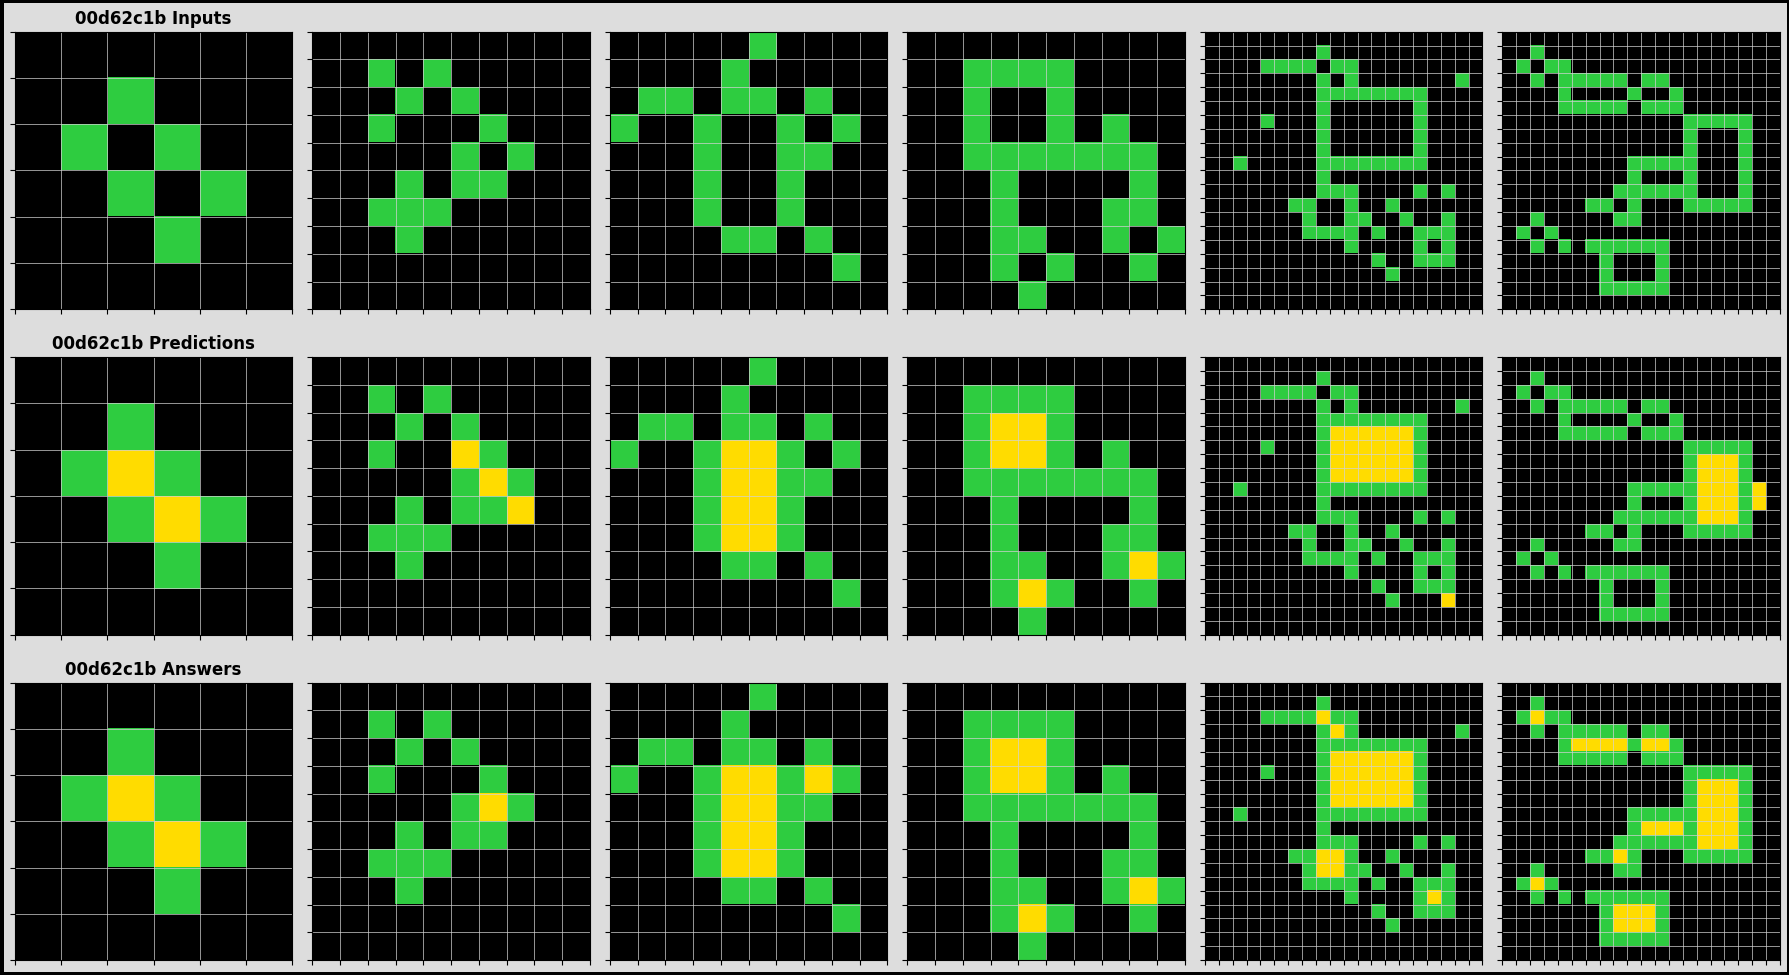

In [19]:
config = load_train_config()
train(config, FillerKeepInput, test=True) # Apply custom model